#### identify nodule from 3 slices

In [1]:
import numpy as np
import cv2
import time
from glob import glob
import os
import matplotlib.pylab as plt
from sklearn.externals import joblib
from skimage import measure
from skimage.transform import resize
import ntpath
%matplotlib inline
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#p = sns.color_palette()
from skimage.draw import circle
#import re
#import traceback
import dicom
import h5py
import random

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print '%s: %s' %(var,module.__version__)
    
# package version    
get_version('numpy','matplotlib','cv2','sklearn','skimage','scipy','pandas')

numpy: 1.11.2
matplotlib: 1.5.1
cv2: 3.1.0
sklearn: 0.18.1
skimage: 0.12.3
scipy: 0.18.1
pandas: 0.19.2


## settings

In [2]:
path2luna="/media/mra/win7/data/misc/kaggle/datascience2017/LUNA2016/"

# data path
root_data='.'
path2dsb=root_data+'/output/data/dsb.hdf5'
path2csv=root_data+'/output/data/stage1_labels.csv'
path2logs='./output/logs/'

# original data dimension
H,W=512,512

# image and label channels
c_in,c_out=3,1

# batch size
bs=16

# trained data dimesnsion
h,w=256,256

# exeriment name to record weights and scores
experiment='luna_nodule_seg_'+'_hw_'+str(h)+'by'+str(w)
print ('experiment:', experiment)

# seed point
seed = 2016
seed = np.random.randint(seed)

# checkpoint
weightfolder='./output/weights/'+experiment
if  not os.path.exists(weightfolder):
    #print ('weights folder does not exist!')
    raise IOError("Path to weights does not exist!")

# number of outputs


nb_output=3 # (r,c,radius)


('experiment:', 'luna_nodule_seg__hw_256by256')


## utils

In [3]:
from keras.models import Model
# functions
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Dropout
from keras.optimizers import Adam
#from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint ,LearningRateScheduler
#from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Activation,Reshape,Permute,Flatten,Dense
#from keras.layers.advanced_activations import ELU
#from keras.models import Model
from keras import backend as K
#from keras.optimizers import Adam#, SGD
#from keras.models import Sequential

# smoothing factor when applying dice
smooth = 1.

def dice_coef(y_true, y_pred):
    smooth=1
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    intersection = 2. * K.sum(y_true_f * y_pred_f, axis=1, keepdims=True) + smooth
    union = K.sum(y_true_f, axis=1, keepdims=True) + K.sum(y_pred_f, axis=1, keepdims=True) + smooth
    return K.mean(intersection / union)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


# model
def seg_model(params):

    h=params['h']
    w=params['w']
    c_in=params['c_in']
    lr=params['learning_rate']
    weights_path=params['weights_path']
    loss=params['loss']
    C=params['nb_filters']
    #num_labels=params['num_labels']
    c_out=params['c_out']
    
    
    
    inputs = Input((c_in,h, w))
    conv1 = Convolution2D(C, 3, 3, activation='relu', subsample=(1,1),border_mode='same')(inputs)
    conv1 = Convolution2D(C, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(2*C, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(2*C, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(4*C, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(4*C, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(8*C, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(8*C, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(16*C, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(16*C, 3, 3, activation='relu', border_mode='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    # last layer of encoding    
    conv6 = Convolution2D(16*C, 3, 3, activation='relu', border_mode='same')(pool5)
    conv6 = Convolution2D(16*C, 3, 3, activation='relu', border_mode='same')(conv6)
    conv6 =Dropout(0.5)(conv6)
    
    # merge layers
    up6 = merge([UpSampling2D(size=(2, 2))(conv6), conv5], mode='concat', concat_axis=1)
    conv6 = Convolution2D(16*C, 3, 3, activation='relu', border_mode='same')(up6)
    #conv6 = Convolution2D(8*C, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv4], mode='concat', concat_axis=1)
    conv7 = Convolution2D(8*C, 3, 3, activation='relu', border_mode='same')(up7)
    #conv7 = Convolution2D(4*C, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv3], mode='concat', concat_axis=1)
    conv8 = Convolution2D(4*C, 3, 3, activation='relu', border_mode='same')(up8)
    #conv8 = Convolution2D(2*C, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv2], mode='concat', concat_axis=1)
    conv9 = Convolution2D(2*C, 3, 3, activation='relu', border_mode='same')(up9)
    #conv9 = Convolution2D(C, 3, 3, activation='relu', border_mode='same')(conv9)

    up10 = merge([UpSampling2D(size=(2, 2))(conv9), conv1], mode='concat', concat_axis=1)
    conv10 = Convolution2D(C, 3, 3, activation='relu', border_mode='same')(up10)
    #conv9 = Convolution2D(C, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(C, 3, 3, activation='relu', border_mode='same')(conv10)
    conv10 = Convolution2D(c_out, 1, 1, activation='sigmoid')(conv10)

    model = Model(input=inputs, output=conv10)

    #load previous weights
    if weights_path:
        model.load_weights(weights_path)

    if loss=='dice':
        model.compile(optimizer=Adam(lr), loss=dice_coef_loss, metrics=[dice_coef])
    else:
        #model.compile(loss='binary_crossentropy', optimizer=Adam(lr))
        model.compile(loss=loss, optimizer=Adam(lr))
    
    return model



# preprocess X and Y
def preprocess_XY(X,Y,param_prep):
    # X,Y: n,c,h,w
    N,C,H,W=X.shape
    
    if Y is None:
        Y=np.zeros_like(X,dtype='uint8')
    else:
        N,Cy,H,W=Y.shape        
    
    # get params
    h=param_prep['h']
    w=param_prep['w']    
    crop=param_prep['crop']
    norm_type=param_prep['norm_type'] # normalization 
    output=param_prep['output'] # output
    
    # center crop h*w
    if crop is 'center':
        hc=(H-h)/2
        wc=(W-w)/2
        X=X[:,:,hc:H-hc,wc:W-wc]
        Y=Y[:,:,hc:H-hc,wc:W-wc]
    elif crop is 'random':
        hc=(H-h)/2
        wc=(W-w)/2
        hcr=np.random.randint(hc)
        wcr=np.random.randint(wc)
        X=X[:,:,hcr:H-hcr,wcr:W-wcr]
        Y=Y[:,:,hcr:H-hcr,wcr:W-wcr]
        
    # check if need to downsample
    # resize if needed
    if h<H:
        X_r=np.zeros([N,C,h,w],dtype=X.dtype)
        Y_r=np.zeros([N,Cy,h,w],dtype='uint8')
        for k1 in range(N):
            for k2 in range(C):
                X_r[k1,k2,:] = cv2.resize(X[k1,k2], (w, h), interpolation=cv2.INTER_CUBIC)
            for k3 in range(Cy):                
                Y_r[k1,k3,:] = cv2.resize(Y[k1,k3], (w, h), interpolation=cv2.INTER_CUBIC)                
    else:
        X_r=X
        Y_r=Y

    # normalization    
    X_r=np.array(X_r,dtype='float32')
    if norm_type is 'global':
        X_r-=np.mean(X_r)
        X_r/=np.std(X_r)
    elif norm_type is 'local':
        for k in range(X_r.shape[0]):
            mean = np.mean(X_r[k,0])  # mean       
            sigma = np.std(X_r[k,0])  # std
            if sigma<1e-5:
                sigma=1
            X_r[k] = X_r[k]-mean
            X_r[k] = X_r[k]/ sigma
    elif norm_type is 'scale':
        X_r-=np.min(X_r)
        X_r/=np.max(X_r)
    elif norm_type is 'minmax_bound':        
        # normalization
        MIN_BOUND = -1000.0
        MAX_BOUND = 400.0
        
        X_r = (X_r - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        X_r[X_r>1] = 1.
        X_r[X_r<0] = 0.

    # center coordinates and diameter
    #y_r=mask2coord(Y_r)            
    #print X_r.shape
    #print Y_r.shape
    #if output is 'mask':    
    return X_r,Y_r
    #elif output is 'coords':
        #return X_r,y_r


def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))



def image_with_mask(img, mask,color=(0,255,0)):
    maximg=np.max(img)    
    img=np.asarray(img,dtype='float32')
    img=np.asarray((img/maximg)*255,dtype='uint8')
    mask=np.asarray(mask,dtype='uint8') 
    if np.max(mask)==1:
        mask=mask*255

    # returns a copy of the image with edges of the mask added in red
    if len(img.shape)==2:	
	img_color = grays_to_RGB(img)
    else:
	img_color =img

    mask_edges = cv2.Canny(mask, 100, 200) > 0
    img_color[mask_edges, 0] = color[0]  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = color[1]
    img_color[mask_edges, 2] = color[2]
    img_color=img_color#/float(np.max(img))
    return img_color

def disp_img_2masks(img,mask1,mask2,r=1,c=1,d=0,indices=None):
    if mask1 is None:
        mask1=np.zeros(img.shape,dtype='uint8')
    if mask2 is None:
        mask2=np.zeros(img.shape,dtype='uint8')
        
    N=r*c    
    if d==2:
        # convert to N*C*H*W
        img=np.transpose(img,(2,0,1))
        img=np.expand_dims(img,axis=1)
        
        mask1=np.transpose(mask1,(2,0,1))
        mask1=np.expand_dims(mask1,axis=1)

        mask2=np.transpose(mask2,(2,0,1))
        mask2=np.expand_dims(mask2,axis=1)
        
    if indices is None:    
        # random indices   
        n1=np.random.randint(img.shape[0],size=N)
    else:
        n1=indices
    
    I1=img[n1,0]
    #M1=mask1[n1,0]
    M1=np.zeros(I1.shape,dtype='uint8')
    for c1 in range(mask1.shape[1]):
        M1=np.logical_or(M1,mask1[n1,c1,:])    
    #M2=mask2[n1,0]
    M2=np.zeros(I1.shape,dtype='uint8')
    for c1 in range(mask2.shape[1]):
        M2=np.logical_or(M2,mask2[n1,c1,:])    
    
    C1=(0,255,9)
    C2=(255,0,0)
    for k in range(N):    
        imgmask=image_with_mask(I1[k],M1[k],C1)
        imgmask=image_with_mask(imgmask,M2[k],C2)
        plt.subplot(r,c,k+1)
        plt.imshow(imgmask)
        plt.title(n1[k])
    plt.show()            
    return n1        




def array_stats(X):
    X=np.asarray(X)
    
    # get var name
    #stack = traceback.extract_stack()
    #filename, lineno, function_name, code = stack[-2]
    #vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    
    #print (vars_name,X.shape, X.dtype)
    print ('array shape',X.shape, X.dtype)
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print ('min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X)))
    
    print '-'*50

# convert mask to coordinates
def mask2coord(Y):
    N,C,H,W=Y.shape
    coords=np.zeros((N,3))
    for k in range(N):
        region=measure.regionprops(Y[k,0])
        if len(region)>0:
            (x,y),radius = cv2.minEnclosingCircle(region[0].coords)
            coords[k,:]=[x,y,radius]
    R=100
    #print np.max(coords[:,2])
    coords=coords/[H,W,R]
    coords=coords[:,:nb_output]
    return coords

# convert coordinates to mask
def coord2mask(y_pred,params):
    h,w,R=params
    n=len(y_pred)
    Y_pred=np.zeros((n,1,h,w),dtype='uint8')
    for k1 in range(n):
        img = np.zeros((h, w), dtype=np.uint8)
        r,c,radius=y_pred[k1,:]*[h,w,R]
        rr, cc = circle(r,c,radius)
        img[rr, cc] = 1
        Y_pred[k1,:]=img
    return Y_pred    



# extract three consecutive images from BS subject
def extract_dsb(trn_nc,bs,df_train):
    # pick bs random subjects
    rnd_nc_inds=random.sample(trn_nc,bs)    
    
    # read h5 file
    f2=h5py.File(path2dsb,'r')
    
    # initialize    
    X=np.zeros((bs,3,H,W),'int16')
    y=np.zeros(bs,dtype='uint8')
    for k,ind in enumerate(rnd_nc_inds):
        p_id=df_train.id[ind]
        #print p_id
    
        X0=f2[p_id]
    
        # pick three concecutive slices
        n1=np.random.randint(len(X0)-3)
        #print n1
        X0=X0[n1:n1+3]
        #array_stats(X0) 
        X[k,:]=X0
    
    f2.close()    
    return X,y

def crop_nodule_roi(X,Y1,Y2,y):
    if Y1 is None:
        Y1=np.zeros_like(X,dtype='uint8')
    if Y2 is None:        
        Y2=np.zeros_like(X,dtype='uint8')
    
    N,C0,H0,W0=X.shape
    hc,wc=128,128
    
    Xc=np.zeros((N,C0,hc,wc))
    Yc1=np.zeros((N,C0,hc,wc),dtype='uint8')
    Yc2=np.zeros((N,C0,hc,wc),dtype='uint8')
    for k in range(N):
        r,c,_=y[k,:]*[H0,W0,100]
        #print r,c
        if r>=hc/2 and (r+hc/2)<=H0:
            r1=int(r-hc/2)
            r2=int(r+hc/2)        
        elif r<hc/2:
            r1=0
            r2=int(r1+hc)
        elif (r+hc/2)>H:
            r2=H0
            r1=r2-hc
            

        if c>=wc/2 and (c+wc/2)<=W0:
            c1=int(c-wc/2)
            c2=int(c+wc/2)        
        elif c<wc/2:
            c1=0
            c2=int(c1+wc)
        elif (c+wc/2)>W:
            c2=W0
            c1=c2-wc
            
            
        #print k,c2-c1,r2-r1,r2,c2,X.shape
        Xc[k,:]=X[k,:,r1:r2,c1:c2]
        Yc1[k,:]=Y1[k,:,r1:r2,c1:c2]
        Yc2[k,:]=Y2[k,:,r1:r2,c1:c2]
    return Xc,Yc1,Yc2        


Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


### load test data from LUNA 2016 data set

In [7]:
# load test data
f1_luna=h5py.File(path2luna+'train_test.hdf5','r')
X_test=f1_luna['X_test']
Y_test=f1_luna['Y_test']

Y_test=Y_test[:,c_out,:][:,np.newaxis,:]

array_stats(X_test)
array_stats(Y_test)


('array shape', (109, 3, 512, 512), dtype('int16'))
min: -3024, max: 7383, avg: -7.81e+02, std:8.25e+02
--------------------------------------------------
('array shape', (109, 1, 512, 512), dtype('uint8'))
min: 0, max: 1, avg: 0.00303, std:0.055
--------------------------------------------------


## AI model

In [5]:
# training params
params_train={
    'h': h,
    'w': w,
    'c_in': c_in,           
    'weights_path': None,        
    'learning_rate': 3e-5,
    'optimizer': 'Adam',
    #'loss': 'binary_crossentropy',
    #'loss': 'mean_squared_error',
    'loss': 'dice',
    'nbepoch': 1000,
    'c_out': c_out,
    'nb_filters': 16,    
    'max_patience': 20    
        }

model = seg_model(params_train)
#model=models.seg_encode_decode(params_train)
model.summary()

# path to weights
path2weights=weightfolder+"/weights.hdf5"


if not os.path.isfile(path2weights):
    raise IOError("Path to weights does not exist!")
else:
    # load best weights
    model.load_weights(path2weights)
    print ('weights loaded!')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 256, 256)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 256, 256)  448         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 256, 256)  2320        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 128, 128)  0           convolution2d_2[0][0]            
___________________________________________________________________________________________

## evaluate AI model on test data from LUNA 2016

In [10]:
# pre-processing 
param_prep={
    'h': h,
    'w': w,
    'crop'    : None,
    'norm_type' : 'minmax_bound',
    'output' : 'coords',
}

score_test=model.evaluate(*preprocess_XY(X_test,Y_test,param_prep),verbose=0)
score_test=score_test[1]   
print 'loss test: %.2f' %score_test

loss test: 0.38


### display some of slices and detected nodules

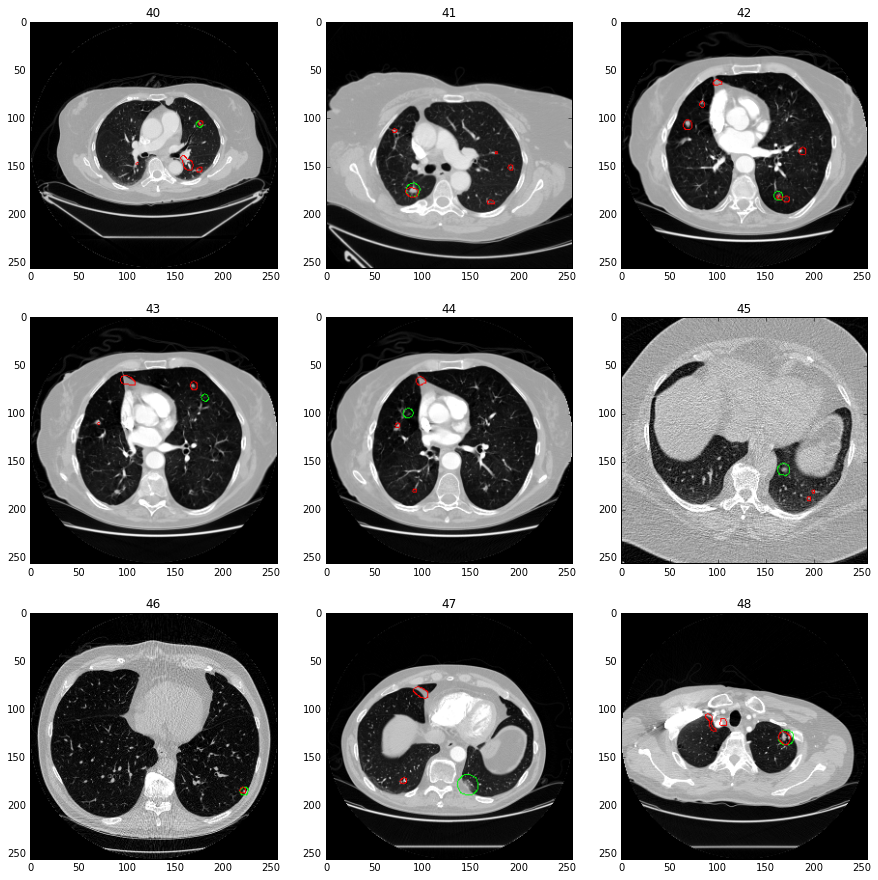

In [26]:

X,Y=preprocess_XY(X_test,Y_test,param_prep)

# prediction
Y_pred=model.predict(X)>0.5    

plt.figure(figsize=(15,15))
n1=disp_img_2masks(X,Y,Y_pred,3,3,0,range(40,49))
plt.show()


In [165]:
f_tt_ind=np.load(weightfolder+'/train_test_indx.npz')
ss_test=f_tt_ind['test']
print ss_test[0]
t1=h5py.File(ss_test[0],'r')
for k in t1.keys()[0:1]:
    print k
    XY=t1[k]
    X0=XY[0]
    Y0=XY[1]
    X1=[]
    step=3
    for k2 in range(0,X0.shape[0]-2,step):
        X1.append(X0[k2:k2+3])
    X1=np.stack(X1)
    Y_pred=model.predict(preprocess_XY(X1,X1,param_prep)[0])
print Y_pred.shape


/media/mra/win7/data/misc/kaggle/datascience2017/LUNA2016/subset5.hdf5
1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd
(52, 1, 256, 256)


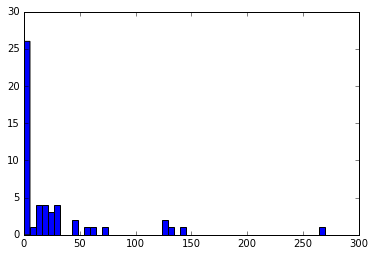

1441.84 27.7276 49.1327


In [167]:
sumYp=np.sum(Y_pred,axis=(1,2,3))
plt.hist(sumYp,50)
plt.show()
print np.sum(sumYp),np.mean(sumYp),np.std(sumYp)


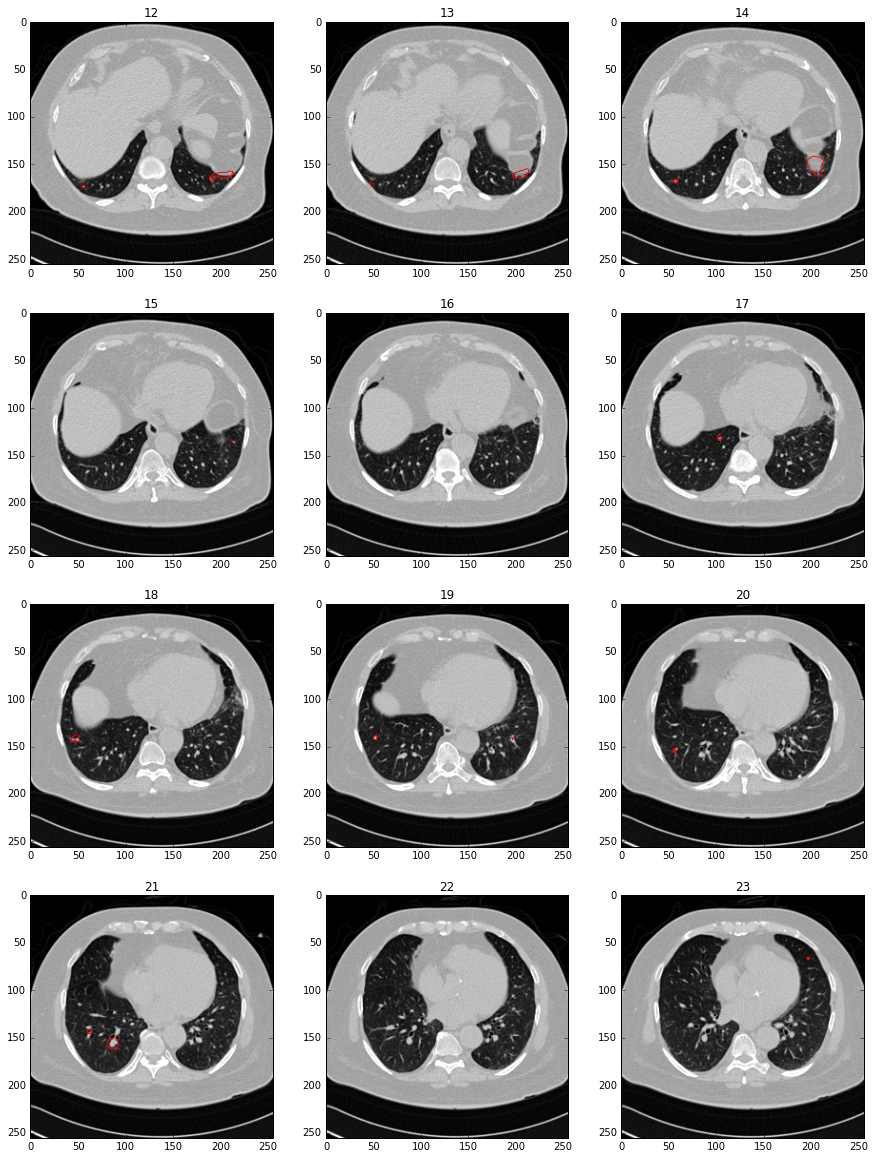

In [173]:
plt.figure(figsize=(15,20))
n=1
X11,_=preprocess_XY(X1,X1,param_prep)
n1=disp_img_2masks(X11,None,Y_pred>.5,4,3,0,range(12*n,np.min([12*n+12 ,len(Y_pred)])))
plt.show()

## DSB data

In [27]:
path2output='./output/data/dsb/'

df_train = pd.read_csv('../stage1_labels.csv')
print('Number of training patients: {}'.format(len(df_train)))
print('Cancer rate: {:.4}%'.format(df_train.cancer.mean()*100))
df_train.head()


Number of training patients: 1397
Cancer rate: 25.91%


,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1


## load DSB 

In [28]:
########## load DSB data, only non-cancer
df_train = pd.read_csv(path2csv)
print('Number of training patients: {}'.format(len(df_train)))
print('Cancer rate: {:.4}%'.format(df_train.cancer.mean()*100))
df_train.head()

# extract non cancers
non_cancer=df_train[df_train.cancer==0].index
cancer=df_train[df_train.cancer==1].index
print 'total non cancer:%s, total cancer:%s' %(len(non_cancer),len(cancer))

# total non cancers
nb_noncancer=len(non_cancer)
y_dsb=np.zeros(nb_noncancer,dtype='uint8')


Number of training patients: 1397
Cancer rate: 25.91%
total non cancer:1035, total cancer:362


In [143]:
# read h5 file
f2=h5py.File(path2dsb,'r')
    
ind=0
p_id=df_train.id[ind]
print p_id,df_train.cancer[ind]
  
X_dsb=f2[p_id]
X_dsb=np.array(X_dsb)
X_dsb=X_dsb[:,np.newaxis]
array_stats(X_dsb)

0015ceb851d7251b8f399e39779d1e7d 1
('array shape', (195, 1, 512, 512), dtype('int16'))
min: -3024, max: 3071, avg: -1.06e+03, std:1.12e+03
--------------------------------------------------


### preprocessing DSB

('array shape', (195, 1, 256, 256), dtype('float32'))
min: 0.0, max: 1.0, avg: 0.268, std:0.343
--------------------------------------------------


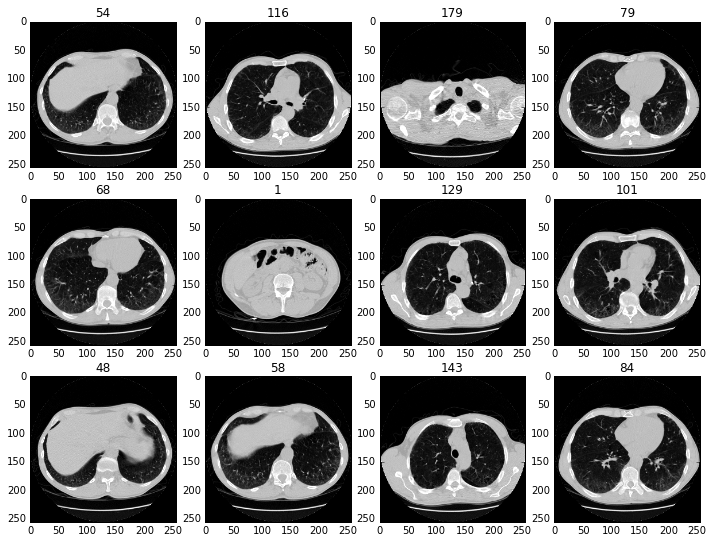

In [144]:
# pre-processing 
param_prep={
    'h': h,
    'w': w,
    'crop'    : None,
    'norm_type' : 'minmax_bound',
    'output' : 'mask',
}

if np.max(X_dsb)>1:
    X_dsb,_=preprocess_XY(X_dsb,X_dsb,param_prep)
array_stats(X_dsb)

t=3
plt.figure(figsize=(4*t,3*t))
n1=disp_img_2masks(X_dsb,None,None,3,4,True)

### test AI model on DSB

In [147]:
X=X_dsb
X1=[]
step=3
for k2 in range(0,X.shape[0]-2,step):
    X1.append(X[k2:k2+3,0])
X1=np.stack(X1)
array_stats(X1)

# prediction
Y_pred=model.predict(X1) 

array_stats(Y_pred)

('array shape', (65, 3, 256, 256), dtype('float32'))
min: 0.0, max: 1.0, avg: 0.268, std:0.343
--------------------------------------------------
('array shape', (65, 1, 256, 256), dtype('float32'))
min: 0.0, max: 1.0, avg: 0.00104, std:0.0296
--------------------------------------------------


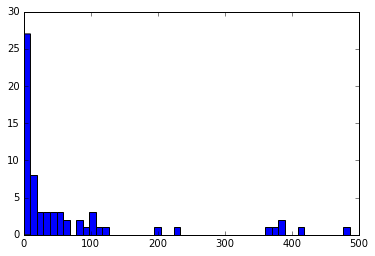

4420.4 68.0062 116.499


In [148]:
sumYp=np.sum(Y_pred,axis=(1,2,3))
plt.hist(sumYp,50)
plt.show()
print np.sum(sumYp),np.mean(sumYp),np.std(sumYp)

#from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=5, random_state=0).fit(sumYp.reshape(-1, 1))
#kmeans.labels_

### display sample slices and detected nodules

IndexError: index 5 is out of bounds for axis 0 with size 5

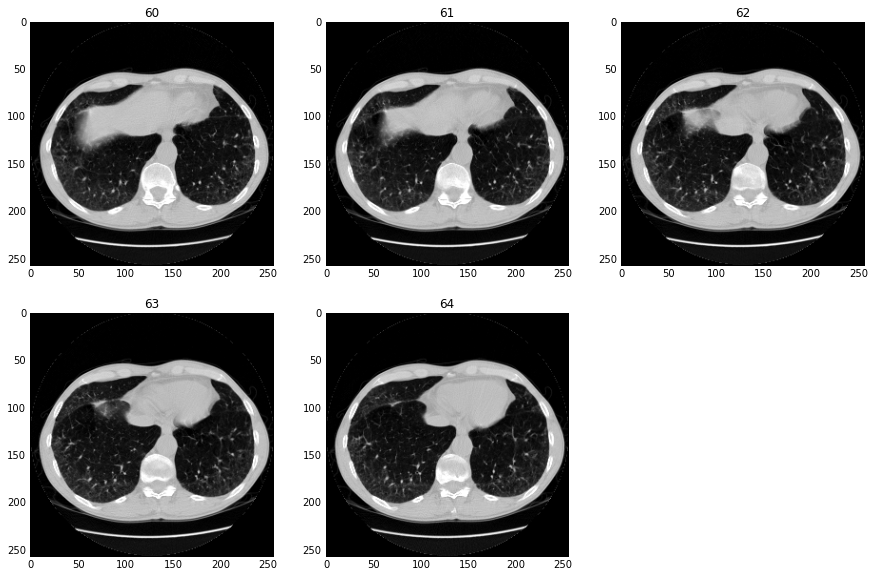

In [153]:
plt.figure(figsize=(15,20))
n=5
n1=disp_img_2masks(X,None,Y_pred>.5,4,3,0,range(12*n,np.min([12*n+12 ,len(Y_pred)])))
plt.show()

In [ ]:
Xc,Yc,_=crop_nodule_roi(X,Y_pred,None,y_pred)

plt.figure(figsize=(15,20))
n=7
n1=disp_img_2masks(Xc,Yc,None,4,3,0,range(12*n,np.min([12*n+12 ,len(Y_pred)])))
plt.show()